<a href="https://colab.research.google.com/github/YuanYuan-11111101001/CyberVSR-2023/blob/main/Unusual_IPs%20and%20PCA%20K-Means%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import plotly
import plotly.express as px
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import scipy.stats as ss

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Functions

In [ ]:
def find_outliers(data, column, include_NaN=False):
  '''
  Identify outliers within a categorical field of a dataframe. Returns dataframe with outlier values.
  Returns an empty dataframe if there are none.

  An outlier is defined as a a value that falls outside three standard deviations of the mean.
  We convert the categorical variables into the frequencies in which each unique value occurs
  within that field. We define the mean as the mean frequency of occurrence and the standard
  deviation as the standard deviation of frequencies. Values with frequencies that are not
  within three standard deviations of the mean frequency will be returned in the dataframe
  '''
  frequencies = data[column].value_counts(normalize=True,dropna=include_NaN)

  data['freq'] = frequencies

  mean = frequencies.mean()
  std = frequencies.std()

  return data[(data['freq'] <= mean-3*std) | (data['freq'] >= mean+3*std)]

In [ ]:
def find_outliers_numerical(data, column):
  '''
  Identify outliers within a categorical field of a dataframe. Returns dataframe with outlier values.
  Returns an empty dataframe if there are none.

  An outlier is defined as a a value that falls outside three standard deviations of the mean.
  We convert the categorical variables into the frequencies in which each unique value occurs
  within that field. We define the mean as the mean frequency of occurrence and the standard
  deviation as the standard deviation of frequencies. Values with frequencies that are not
  within three standard deviations of the mean frequency will be returned in the dataframe
  '''

  mean = data[column].mean()
  std = data[column].std()

  return data[(data[column] <= mean-3*std) | (data[column] >= mean+3*std)]

In [ ]:
def most_common(data, columns):
  '''
  Returns the most common value in a dataframe's selected columns
  '''
  # df.fillna("NAN",inplace=True)
  most_common = []
  counts = []
  for column in columns:
    # most_common.append(data[column].mode())
    popular = data[column].value_counts(dropna=False)
    most_common.append(popular.index[0])
    counts.append(popular[0])
  d = {'column': columns, 'most_common_value': most_common, 'count':counts}
  return pd.DataFrame(data=d)

In [ ]:
def n_most_common(data, columns, n, include_NaN=False):
  '''
  Returns the n most common values within a dataframe's (data) selected columns (columns)
  '''
  for column in columns:
    most = data[column].value_counts(dropna=include_NaN).nlargest(n)
    most['column_name'] = column

  return most

In [ ]:
def find_percentile(df, column, score, give_percentile = True):
  if give_percentile:
    # returns the percentile of the score in the df[column] array
    return ss.percentileofscore(df[column], score)
  else:
    # returns the value at the score percentile in df[column]
    return np.percentile(df[column], score)

In [ ]:
def range_group(df, column, bottom_percent, top_percent):
  '''
  return dataframe where values in df[column] fall between the bottom_percent percentile
  and the top_percent percentile.
  '''
  return df[(df[column] >= np.percentile(df[column], bottom_percent)) & (df[column] <= np.percentile(df[column], top_percent))]

In [ ]:
def label_freq(df, column, threshold_high, threshold_med):
  # for value in df[column]:
  #   if value >= threshold_high:
  #     df['threshold']

  df = df.copy()
  conditions = [(df[column] >= threshold_high), ((df[column] < threshold_high) & (df[column] >= threshold_med)), (df[column] < threshold_med)]

  values = ['frequent', 'moderate', 'infrequent']

  df['frequency'] = np.select(conditions, values)

  return df

In [ ]:
def label_longevity(df, column, threshold_high, threshold_med):
  # for value in df[column]:
  #   if value >= threshold_high:
  #     df['threshold']

  # convert seconds to days
  df = df.copy()
  in_days = df[column]//86400

  conditions = [(df[column] >= threshold_high), ((df[column] < threshold_high) & (df[column] >= threshold_med)), (df[column] < threshold_med)]

  values = ['long', 'medium', 'short']

  df['longevity'] = np.select(conditions, values)

  return df

In [ ]:
def typicality(df, column, percentile):

  df = df.copy()
  percentile_value = find_percentile(df, column, percentile, give_percentile = False)

  df['typicality ' + column] = np.where(df[column] >= percentile_value, 'atypical', 'typical')
  return df

In [ ]:
def get_valid_ips(df):
  '''
  Returns dataframe of ips that have 3 or more nonempty entries in at least one of
  fields: username, ssh_username, or command.

  Note that an ip with 2 nonempty entries in username and one nonempty entry
  in ssh_username is not considered valid, but an ip with 3 nonempty entries in
  username is valid.
  '''

  # Use transformed dataset fields to get number of valid entries

  return df[(df['num_valid username'] > 2) | (df['num_valid ssh_username'] > 2) | (df['num_valid command'] > 2)]

def case_one(df):
  '''
  Returns dataframe of unusual ips that fall under case one.
  Where case one of unusual ips is defined as ips with high cross entropy values in
  at least two of the following fields: username, ssh_username, and command.

  IPs are considered valid iff there are 3 or more nonempty entries in the field
  corresponding to the low entropy value.

  A high cross entropy value is defined as a cross entropy  value that falls above the 90th percentile
  in respective cross entropy field's overall distribution (including invalid ips)
  '''

  df_username = df[df['num_valid username'] >= 3]
  df_ssh_username = df[df['num_valid ssh_username'] >= 3]
  df_command = df[df['num_valid command'] >= 3]

  per_u = find_percentile(df, 'ce username', 97.5, give_percentile = False)
  per_sshu = find_percentile(df, 'ce ssh_username', 97.5, give_percentile = False)
  per_c = find_percentile(df, 'ce command', 97.5, give_percentile = False)

  # u_sshu = pd.merge(per_u, per_sshu, how='inner')
  # sshu_c = pd.merge(per_c, per_sshu, how='inner')
  # u_c = pd.merge(per_c, per_u, how='inner')

  # all_overlaps = pd.concat([u_sshu, sshu_c, u_c])

  df_username = df_username[df_username['ce username'] >=per_u]
  df_ssh_username = df_ssh_username[df_ssh_username['ce ssh_username'] >=per_sshu]
  df_command = df_command[df_command['ce command'] >=per_c]

  all_overlaps = pd.concat([df_username, df_ssh_username, df_command])
  return all_overlaps[all_overlaps.duplicated()]
  # return all_overlaps.drop_duplicates(subset='src_ip')


def case_two(df):
  '''
  Returns dataframe of unusual ips that fall under case two.
  Where case two of unusual ips is defined as ips with low entropy (less than 0.25)
  in fields: username, ssh_username, and command.

  IPs are considered valid iff there are 3 or more nonempty entries in the field
  corresponding to the low entropy value.
  '''
  low_u = df[(df['num_valid username'] >= 3) & (df['entropy username'] < 0.5)]
  low_sshu = df[(df['num_valid ssh_username'] >= 3) & (df['entropy ssh_username'] < 0.5)]
  low_c = df[(df['num_valid command'] >= 3) & (df['entropy command'] < 0.5)]

  all_with_low = pd.concat([low_u, low_sshu, low_c])

  return all_with_low.drop_duplicates(subset='src_ip'), all_with_low[all_with_low.duplicated()]

## Work

In [ ]:
counts = pd.DataFrame()

counts['count'] = february['command'].value_counts()

In [ ]:
use = counts[counts['count'] >= 10]

check_commands = []
for command in use.index:
  if (february[february['command']==command]['src_ip'].nunique() <= 7) & (february[february['command']==command]['src_ip'].nunique() > 1):
    check_commands.append(command)

In [ ]:
check_commands

['echo -e "\\x6F\\x6B"', 'runshellcmd']

In [ ]:
february[february['command']=='runshellcmd']['src_ip'].value_counts()

41.66.128.252    8
87.163.61.167    8
Name: src_ip, dtype: int64

In [ ]:
february[february['src_ip'] == '87.163.61.167']['command'].nunique() #.dropna(subset=['command'])

36

In [ ]:
c1_w5 = case_one(w5)
c1_w6 = case_one(w6)
c1_w7 = case_one(w7)
c1_w8 = case_one(w8)
c1_w9 = case_one(w9)

In [ ]:
c2_w5, xc2_w5 = case_two(w5)
c2_w6, xc2_w6 = case_two(w6)
c2_w7, xc2_w7 = case_two(w7)
c2_w8, xc2_w8 = case_two(w8)
c2_w9, xc2_w9 = case_two(w9)

In [ ]:
# february[february['command'] == 'echo -e "\x6F\x6B"']
co = pd.DataFrame()
co['counts'] = february['command'].value_counts()

In [ ]:
c2_w9[c2_w9['entropy command'] != 0]

,src_ip,attack_frequency,entropy src_port,entropy dest_port,entropy sensor,entropy username,entropy ssh_username,entropy command,num_valid username,num_valid ssh_username,...,num_outliers dest_port,num_outliers sensor,num_common src_port,num_common dest_port,num_common sensor,ce src_port,ce dest_port,ce username,ce ssh_username,ce command
2032,180.115.132.85,31,0.999249,-0.0,-0.0,-0.0,-0.0,3.70044,0,3,...,0.0,0.0,0,0,31,10.419896,3.66907,-0.0,1.322769,5.783638


In [ ]:
w5[w5['src_ip'] == '195.14.105.97']

,src_ip,attack_frequency,entropy src_port,entropy dest_port,entropy sensor,entropy username,entropy ssh_username,entropy command,num_valid username,num_valid ssh_username,...,num_outliers dest_port,num_outliers sensor,num_common src_port,num_common dest_port,num_common sensor,ce src_port,ce dest_port,ce username,ce ssh_username,ce command
6224,195.14.105.97,86,4.878162,-0.0,-0.0,-0.0,-0.0,-0.0,0,28,...,0.0,0.0,0,86,86,13.490277,3.006853,-0.0,0.783344,7.59885


In [ ]:
# one = w5[w5['src_ip'] == '195.14.105.97']
two = w6[w6['src_ip'] == '41.66.128.252']
three = w8[w8['src_ip'] == '87.163.61.167']
# 41.66.128.252 (w6) and 87.163.61.167
# four = w8[w8['src_ip'] == '177.248.217.207']
# five = w7[w7['src_ip'] == '106.168.239.111']

# four = df[w6['src_ip'] == '41.66.128.252']
# five = df[w8['src_ip'] == '87.163.61.167']

details = pd.concat([two, three])

In [ ]:
px.histogram(all_details['ce command'])

In [ ]:
df = february
# one = august[august['src_ip'] == '82.157.251.66']
# five_unusuals = df[(df['src_ip'] == '195.14.105.97')| (df['src_ip'] == '157.120.41.23') | (df['src_ip'] == '118.69.60.214') | (df['src_ip'] == '177.248.217.207') | (df['src_ip'] == '106.168.239.111')]
five_unusuals = df[(df['src_ip'] == '41.66.128.252')| (df['src_ip'] == '87.163.61.167')]
# five_unusuals = pd.concat([one, five_unusuals])
fig = px.scatter(five_unusuals, y="src_ip", x="timestamp", title='Attack Timeline of 2 Similar IPs with Exclusive Command')
fig.show()

195.14.105.97 (w5), 157.120.41.23 (w6), 118.69.60.214 (w8), 177.248.217.207 (w8), and 106.168.239.111 (w7) use only echo -e "\x6F\x6B"

195.14.105.97 uses root only, numbers and words huangtao

157.120.41.23 root only, pw numbers and words

118.69.60.214 uses root as ssh_username only, with numbers

177.248.217.207 uses root as ssh_username only, with words

106.168.239.111 uses root only, some numbers so with names/words zhoufeng

do only these ips use this? do they have anything else the same.

special command and high cross entropy
echo -e "\x6F\x6B" appears 92 times. only from these 5 ips

what times do these ips appear for.
low entropy for command, high cross entropy for command

82.157.251.66 in august same.

41.66.128.252 (w6) and 87.163.61.167 (w8) use same command and are the only ones who use it. Had same exact number of unique commands (36) and same number of valid commands used (79). Command used: 'runshellcmd'

46.19.143.2 only uses sa and ?sa (week 5 only) usernames. All usernames have passwords. appears in case 2 in week 5 and 6. Same person? But many use sa. However, have similar ce's for src_port and dest_port

198.199.117.107 (w7) high ce for ssh_username and command

110.180.153.4, 113.221.27.6, 121.224.181.48 (w7) - extremely similar attack_freq, command entropy, and all cross entropies. similar commands

high exclusivity. look at 2 other months. similar commands/others in the other 2

In [ ]:
work = df_feb.drop(columns = ['ce_nan username', 'ce_nan ssh_username',
       'ce_nan command', 'ce_all src_port', 'ce_all dest_port',
       'ce_all sensor', 'ce_all username', 'ce_all ssh_username',
       'ce_all command', 'ce_nan_all username', 'ce_nan_all ssh_username',
       'ce_nan_all command'])

work = work[(work['num_valid username'] != 0) & (work['unique_valid username'] > 1)]
work[['src_ip', 'attack_frequency', 'num_valid username', 'unique_valid username', 'entropy username', 'ce username']]

In [ ]:
work[work['src_ip'] == '46.19.143.34'].transpose()

,32805
src_ip,46.19.143.34
attack_frequency,102
attack_duration,239277.769644
entropy src_port,5.692033
entropy dest_port,-0.0
entropy sensor,-0.0
entropy username,5.383114
entropy ssh_username,-0.0
entropy command,-0.0
num_valid username,51


In [ ]:
df_feb[(df_feb['num_valid ssh_username']!=0) & (df_feb['num_valid command']!=0)][['src_ip','num_valid username','num_valid ssh_username', 'num_valid command']]

,src_ip,num_valid username,num_valid ssh_username,num_valid command
14,1.129.109.74,0,3,3
155,1.196.242.90,0,2,13
172,1.214.245.27,0,6,6
179,1.22.115.245,0,2,13
226,1.22.168.89,0,1,13
...,...,...,...,...
39731,98.157.228.234,0,4,13
39746,98.243.72.196,0,3,3
39747,98.248.92.175,0,3,3
39765,99.149.251.77,0,3,2


In [ ]:
f[(f['src_ip']=='139.144.52.241') & ((f['username'].notnull()) | (f['ssh_username'].notnull()) | (f['command'].notnull()))]

In [ ]:
df_feb[(df_feb['attack_frequency']>=10) & (df_feb['num_valid username'] > 3)]

,src_ip,attack_frequency,attack_duration,entropy src_port,entropy dest_port,entropy sensor,entropy username,entropy ssh_username,entropy command,num_valid username,...,ce_nan command,ce_all src_port,ce_all dest_port,ce_all sensor,ce_all username,ce_all ssh_username,ce_all command,ce_nan_all username,ce_nan_all ssh_username,ce_nan_all command
13,1.119.194.253,28,1.869029e+06,3.878783,-0.000000,1.413800,-0.0,-0.0,-0.0,5,...,0.114613,14.949646,3.748693,4.140273,0.046596,-0.0,-0.0,1.053114,0.055465,0.105129
161,1.202.17.93,32,1.974615e+06,4.000000,-0.000000,1.579434,-0.0,-0.0,-0.0,7,...,0.114613,15.043530,3.748693,3.932275,0.057080,-0.0,-0.0,1.282743,0.055465,0.105129
744,101.53.100.155,26,1.971956e+06,4.008132,0.890492,2.141620,-0.0,-0.0,-0.0,4,...,0.114613,15.338096,3.400949,3.993750,0.040144,-0.0,-0.0,0.911803,0.055465,0.105129
766,101.69.206.211,24,6.789086e+05,3.584963,-0.000000,1.459148,-0.0,-0.0,-0.0,8,...,0.114613,15.859175,3.748693,3.897911,0.086980,-0.0,-0.0,1.937614,0.055465,0.105129
908,103.10.87.52,14,2.198833e+05,2.807355,-0.000000,1.556657,-0.0,-0.0,-0.0,4,...,0.114613,14.896174,3.748693,3.414136,0.074554,-0.0,-0.0,1.665460,0.055465,0.105129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39250,93.41.214.165,10,2.106302e+06,2.321928,-0.000000,2.321928,-0.0,-0.0,-0.0,5,...,0.114613,15.142465,3.748693,3.785081,0.130469,-0.0,-0.0,2.890153,0.055465,0.105129
39277,93.76.197.167,24,1.906588e+06,3.584963,-0.000000,1.918296,-0.0,-0.0,-0.0,6,...,0.114613,15.724630,3.748693,3.675936,0.065235,-0.0,-0.0,1.461345,0.055465,0.105129
39319,94.127.214.136,17,1.830236e+06,3.381580,0.997503,2.278352,-0.0,-0.0,-0.0,4,...,0.114613,17.405791,3.150368,3.862810,0.061397,-0.0,-0.0,1.377297,0.055465,0.105129
39377,94.23.219.59,12,2.087053e+06,2.584963,-0.000000,2.251629,-0.0,-0.0,-0.0,6,...,0.114613,15.227465,3.748693,3.602044,0.130469,-0.0,-0.0,2.890153,0.055465,0.105129


# Plan for Clustering:

do individual clustering on time periods use cross entropy for with respect.

feature selection, feature reduction. Which features are important?

In [ ]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
df_feb_use.columns

Index(['src_ip', 'attack_frequency', 'attack_duration', 'entropy src_port',
       'entropy dest_port', 'entropy sensor', 'entropy username',
       'entropy ssh_username', 'entropy command', 'num_valid username',
       'num_valid ssh_username', 'num_valid command', 'percent_valid username',
       'percent_valid ssh_username', 'percent_valid command',
       'unique_valid username', 'unique_valid ssh_username',
       'unique_valid command', 'num_outliers src_port',
       'num_outliers dest_port', 'num_outliers sensor', 'num_common src_port',
       'num_common dest_port', 'num_common sensor', 'ce src_port',
       'ce dest_port', 'ce sensor', 'ce username', 'ce ssh_username',
       'ce command', 'ce_nan username', 'ce_nan ssh_username',
       'ce_nan command', 'ce_all src_port', 'ce_all dest_port',
       'ce_all sensor', 'ce_all username', 'ce_all ssh_username',
       'ce_all command', 'ce_nan_all username', 'ce_nan_all ssh_username',
       'ce_nan_all command', 'frequency', '

## PCA dimensionality reduction

In [ ]:
# dimensionality
dff = df_feb_use[df_feb_use['frequency'] != 'infrequent']
dff = dff.drop(columns=['src_ip', 'ce sensor', 'ce_nan username', 'ce_nan ssh_username',
       'ce_nan command', 'ce_all src_port', 'ce_all dest_port',
       'ce_all sensor', 'ce_all username', 'ce_all ssh_username',
       'ce_all command', 'ce_nan_all username', 'ce_nan_all ssh_username',
       'ce_nan_all command'])

df = dff.drop(columns=['frequency', 'longevity',
       'typicality ce src_port', 'typicality ce dest_port',
       'typicality ce username', 'typicality ce ssh_username',
       'typicality ce command'])

# df = df[df['frequency'] != 'infrequent']
segmentation_std = StandardScaler().fit_transform(df)

pca = PCA()
pca.fit(segmentation_std)

PCA()

In [ ]:
pca.explained_variance_ratio_

array([3.00095954e-01, 1.18659850e-01, 1.07380315e-01, 1.01752121e-01,
       8.13301897e-02, 4.85696472e-02, 4.04236582e-02, 3.82455333e-02,
       2.88036859e-02, 2.26335047e-02, 1.99153921e-02, 1.42884152e-02,
       1.25583552e-02, 1.12765858e-02, 1.01939467e-02, 8.42089773e-03,
       8.07803743e-03, 7.01137031e-03, 5.48074467e-03, 4.75172574e-03,
       2.92586103e-03, 2.80273259e-03, 1.78396516e-03, 1.21166367e-03,
       7.77925744e-04, 5.48597792e-04, 7.93239548e-05, 2.25332476e-33])

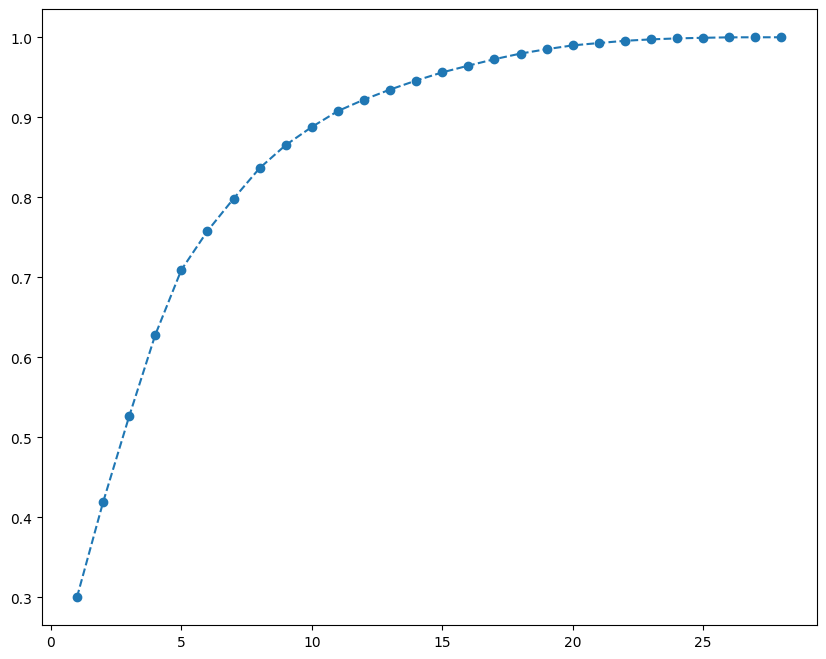

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(range(1,29), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

# TODO get rid of cross entropy we don't need for the month
# look for keeping 0.8 variance

In [ ]:
pca = PCA(n_components = 7)  # figure out how many
pca.fit(segmentation_std)

PCA(n_components=7)

In [ ]:
pca.transform(segmentation_std)
scores_pca = pca.transform(segmentation_std)

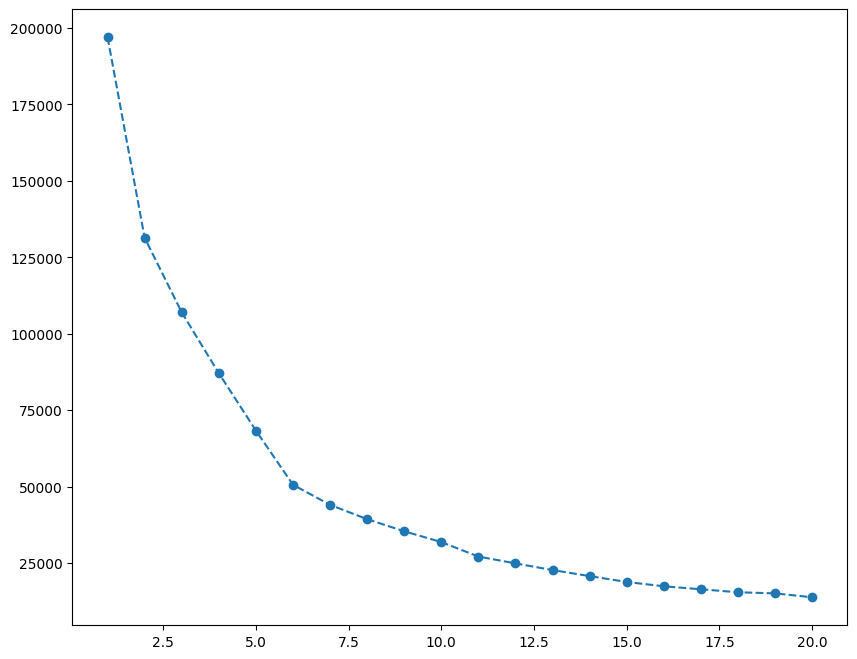

In [ ]:
# https://365datascience.com/tutorials/python-tutorials/pca-k-means/
# from sklearn import KMeans
wcss= []
for i in range(1,21):
  kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans_pca.fit(scores_pca)
  wcss.append(kmeans_pca.inertia_)

plt.figure(figsize = (10,8))
plt.plot(range(1,21), wcss, marker='o', linestyle='--')
plt.show()

In [ ]:
kmeans_pca = KMeans(n_clusters = 6, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=6, random_state=42)

In [ ]:
dff['Kmeans PCA Cluster'] = kmeans_pca.labels_

In [ ]:
# df_segm_pca_kmeans['Kmeans PCA Relative'].value_counts()
dff['Kmeans PCA Cluster'].value_counts()

2    4383
1    2419
0    1272
3    1053
4       9
5       1
Name: Kmeans PCA Cluster, dtype: int64

In [ ]:
cluster_zero = dff[dff['Kmeans PCA Cluster']==0]
cluster_one = dff[dff['Kmeans PCA Cluster']==1]
cluster_two = dff[dff['Kmeans PCA Cluster']==2]
cluster_three = dff[dff['Kmeans PCA Cluster']==3]
cluster_four = dff[dff['Kmeans PCA Cluster']==4]
cluster_five = dff[dff['Kmeans PCA Cluster']==5]

In [ ]:
px.histogram(df_feb_use['typicality ce username'])

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(fig.add_trace(go.Histogram(x=x0), name = ))
# 'ce src_port','ce dest_port','ce username', 'ce ssh_username','ce command']

px.histogram(cluster_three['typicality ce ssh_username'], title = 'Distribution of Typicality of ssh_username in Cluster Three')